Nieuw idee: Indien werken met documenten evt document als context zien, en hiervoor unieke vector maken. Deze vervolgens multisetten.

In [1]:
# from nltk.tokenize import sent_tokenize
import re
from tqdm import tqdm
import gensim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchhd

from torchhd import embeddings, memory, structures
from nltk import ngrams
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# import nltk
# from wordcloud import WordCloud

## Reading Data

In [2]:
with open("../../data_external/Harry_Potter_all_books_preprocessed.txt") as f:
    data = f.read()

In [3]:
data[:1000]

'THE BOY WHO LIVED Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you very much .They were the last people youd expect to be involved in anything strange or mysterious because they just didnt hold with such nonsense .Mr Dursley was the director of a firm called Grunnings which made drills .He was a big beefy man with hardly any neck although he did have a very large mustache .Mrs Dursley was thin and blonde and had nearly twice the usual amount of neck which came in very useful as she spent so much of her time craning over garden fences spying on the neighbors .The Dursley s had a small son called Dudley and in their opinion there was no finer boy anywhere .The Dursleys had everything they wanted but they also had a secret and their greatest fear was that somebody would discover it .They didnt think they could bear it if anyone found out about the Potters .Mrs Potter was Mrs Dursleys sister but they hadnt met for several years in 

## Data Cleaning

Now we can apply this to entire corpus

In [4]:
data = re.sub(r'\s\.([A-Z])', r'. \1', data) # remove space before dot and capital letter and replace with dot, space and capital letter
print(data[:1000])

THE BOY WHO LIVED Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you very much. They were the last people youd expect to be involved in anything strange or mysterious because they just didnt hold with such nonsense. Mr Dursley was the director of a firm called Grunnings which made drills. He was a big beefy man with hardly any neck although he did have a very large mustache. Mrs Dursley was thin and blonde and had nearly twice the usual amount of neck which came in very useful as she spent so much of her time craning over garden fences spying on the neighbors. The Dursley s had a small son called Dudley and in their opinion there was no finer boy anywhere. The Dursleys had everything they wanted but they also had a secret and their greatest fear was that somebody would discover it. They didnt think they could bear it if anyone found out about the Potters. Mrs Potter was Mrs Dursleys sister but they hadnt met for several years in f

In [5]:
# # strip punctuation
# data = gensim.parsing.preprocessing.strip_punctuation(data)
# print(data[:1000])

# # strip numeric characters
# data = gensim.parsing.preprocessing.strip_numeric(data)
# print(data[:1000])

# # strip multiple whitespaces
# data = gensim.parsing.preprocessing.strip_multiple_whitespaces(data)
# print(data[:1000])

# strip stopwords
# data = gensim.parsing.preprocessing.remove_stopwords(data)
# print(data[:1000])

# # convert to lowercase
# data = data.lower()

# tokenize
data = gensim.utils.simple_preprocess(data, deacc=True)
print(data[:100])

# remove stopwords
data = gensim.parsing.preprocessing.remove_stopword_tokens(data)
print(data[:20])
# data = np.array(data)

# data = data[:100_000]


['the', 'boy', 'who', 'lived', 'mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'youd', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didnt', 'hold', 'with', 'such', 'nonsense', 'mr', 'dursley', 'was', 'the', 'director', 'of', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'very', 'large', 'mustache', 'mrs', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent']
['boy', 'lived', 'mr', 'mrs', 'dursley', 'number', 'privet', 'drive', 'proud', 'perfectly', 'normal', 'thank', 'people', 'youd', 'expect', 'involved', 'strang

Create ngrams from tokenized dataset

In [6]:
ngram_size = 5
n_grams = list(ngrams(data, ngram_size))
print(n_grams[:10])

[('boy', 'lived', 'mr', 'mrs', 'dursley'), ('lived', 'mr', 'mrs', 'dursley', 'number'), ('mr', 'mrs', 'dursley', 'number', 'privet'), ('mrs', 'dursley', 'number', 'privet', 'drive'), ('dursley', 'number', 'privet', 'drive', 'proud'), ('number', 'privet', 'drive', 'proud', 'perfectly'), ('privet', 'drive', 'proud', 'perfectly', 'normal'), ('drive', 'proud', 'perfectly', 'normal', 'thank'), ('proud', 'perfectly', 'normal', 'thank', 'people'), ('perfectly', 'normal', 'thank', 'people', 'youd')]


# Initial data analysis

Lenght of data

In [7]:
print(len(data))

512519


Creating and looking at the vocabulary

In [8]:
vocab = sorted(list(set(data)))
print(len(vocab))

22719


Word frequency analysis

In [9]:
# word frequency
word_freq = {}
for word in data:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

# sort word frequency
word_freq = {k: v for k, v in sorted(word_freq.items(), key=lambda item: item[1], reverse=True)}

# print top 10 words
print(list(word_freq.items())[:10])


[('harry', 16750), ('said', 14491), ('ron', 5820), ('hermione', 5109), ('dumbledore', 3020), ('like', 2379), ('looked', 2361), ('know', 2286), ('got', 2081), ('professor', 2031)]


# Define Distance Functions

In [10]:
# def hamming_distance(a: np.array, b: np.array):
#     if a.shape[0] != b.shape[0]:
#         raise ValueError("a and b must have the same shape")
#     return np.sum[a != b] / a.shape[0]

# def cosine_distance(a, b):
#   if np.linalg.norm(a, ord=2) == 0 or np.linalg.norm(b, ord=2) == 0:
#     return 0
#   return np.dot(a, b) / (np.linalg.norm(a, ord=2) * np.linalg.norm(b, ord=2))

# Onto HD space

In [11]:
DIMENSIONS = 10_000
vocab_size = len(vocab)
HDtype = 'MAP'
# null_vector = torchhd.empty(1, DIMENSIONS, HDtype)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))


Using cuda device


Create a hash table; words to index

In [12]:
word_to_index = {word: i for i, word in enumerate(vocab)}

convert ngrams: list[ngrams] to list[(context, target)]

In [13]:

n_grams_transformed = [
    (
        list(ngram[:ngram_size // 2] + ngram[ngram_size // 2 + 1:]),
        ngram[ngram_size // 2]
    )
    for ngram in n_grams
]
print(n_grams_transformed[:10])

[(['boy', 'lived', 'mrs', 'dursley'], 'mr'), (['lived', 'mr', 'dursley', 'number'], 'mrs'), (['mr', 'mrs', 'number', 'privet'], 'dursley'), (['mrs', 'dursley', 'privet', 'drive'], 'number'), (['dursley', 'number', 'drive', 'proud'], 'privet'), (['number', 'privet', 'proud', 'perfectly'], 'drive'), (['privet', 'drive', 'perfectly', 'normal'], 'proud'), (['drive', 'proud', 'normal', 'thank'], 'perfectly'), (['proud', 'perfectly', 'thank', 'people'], 'normal'), (['perfectly', 'normal', 'people', 'youd'], 'thank')]


In [14]:
class NGramEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, HDtype='MAP'):
        super(NGramEncoder, self).__init__()
        # thinning_factor = 0.8
        # label_embeddings_thinned = torch.bernoulli(torch.ones(vocab_size, embedding_dim) * thinning_factor)
        # label_embeddings_thinned = torchhd.ensure_vsa_tensor(label_embeddings_thinned, HDtype)
        # self.label_embeddings = torchhd.hard_quantize(label_embeddings_thinned)
        self.label_embeddings = torchhd.random(vocab_size, 
                                              embedding_dim,
                                              HDtype)
        # self.learned_embeddings = torchhd.empty(vocab_size, embedding_dim, HDtype)
        self.embedding_dim = embedding_dim
        self.HDtype = HDtype

    def encode(self, input_window_idxs):
        context_idxs = torchhd.empty(input_window_idxs.shape[0], self.embedding_dim, self.HDtype)
        for i, context_idx in enumerate(input_window_idxs):
            context_idxs[i] = self.label_embeddings[context_idx]
        context_vec = torchhd.multiset(context_idxs)
        # context_vec = torchhd.hard_quantize(context_vec) # hard_quantize does not take HDtype into account, is only usable for MAP type
        return context_vec
        

    def forward(self, input_window_idxs):
        encoded = self.encode(input_window_idxs)
        return encoded
    
learned_embeddings = torchhd.empty(vocab_size, DIMENSIONS, HDtype)

encoder = NGramEncoder(vocab_size, DIMENSIONS, HDtype)
# encoder = encoder.to(device)
# learned_embeddings = learned_embeddings.to(device)
        

In [15]:

# ngram_dl = DataLoader(n_grams, batch_size=1, shuffle=True)

# convert n_grams to idx_tensors
n_gram_tensors = [
    (
        torch.tensor([word_to_index[word] for word in context], dtype=torch.long),#, device=device),
        word_to_index[target]
    )
    for context, target in n_grams_transformed
]

with torch.no_grad(): # avoid tracking gradient history
  for n_gram in tqdm(n_gram_tensors, total=len(data), desc="Training"):
      
      context_idxs, target_idx = n_gram

      context_embedding = encoder(context_idxs)

      learned_embeddings[target_idx] = torchhd.bundle(learned_embeddings[target_idx], context_embedding)


Training: 100%|█████████▉| 512515/512519 [01:35<00:00, 5391.52it/s]


Some data analysis helper functions

In [16]:
# get most similar vectors to word
def get_k_most_similar_words(target_word, learned_memory, k=10, label_memory=None):
    word_idx = word_to_index[target_word]
    word_vector = learned_memory[word_idx]
    comparable_memory = label_memory if label_memory is not None else learned_memory
    similar_vectors = torchhd.cosine_similarity(word_vector, comparable_memory)
    similar_vector_idxs = torch.argsort(similar_vectors, descending=True)[:k]
    return [(vocab[idx], round(similar_vectors[idx].item(), 3)) for idx in similar_vector_idxs]

def plot_k_most_similar_words(target_word, memory, k=10):
    similar_vectors = get_k_most_similar_words(target_word, memory, k)
    similar_words = [word for word, similarity in similar_vectors]
    similarities = [similarity for word, similarity in similar_vectors]
    ax = sns.barplot(x=similar_words, y=similarities)
    ax.set_title(f"Most similar words to {target_word}")
    ax.set_xlabel("Similarity")
    ax.set_ylabel("Word")
    ax.bar_label(ax.containers[0])
    plt.xticks(rotation=90)
    plt.show()
    
def get_freq_context_words(target_word, n_grams=n_grams_transformed):
    data_filtered = [context for context, target in n_grams if target == target_word]
    word_freq = {}
    for context in data_filtered:
        for word in context:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    word_freq = {k: v for k, v in sorted(word_freq.items(), key=lambda item: item[1], reverse=True)}
    return word_freq

/home/senn/anaconda3/envs/hdd/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/senn/anaconda3/envs/hdd/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/senn/anaconda3/envs/hdd/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/senn/anaconda3/envs/hdd/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dty

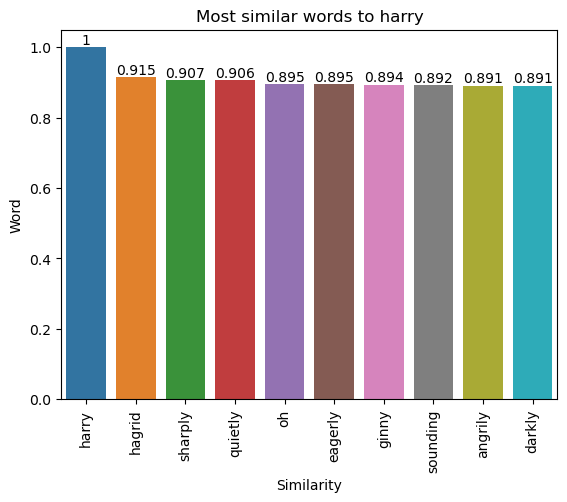

In [17]:
plot_k_most_similar_words('harry', learned_embeddings, k=10)

In [18]:
target_word = 'harry' 
context_freq = get_freq_context_words(target_word)
print(context_freq)

for word, similarity in get_k_most_similar_words(target_word, learned_embeddings, k=10):
    print(word, context_freq[word], similarity)

print(torchhd.cosine_similarity(learned_embeddings[word_to_index['ron']], learned_embeddings[word_to_index[target_word]]))
print(torchhd.cosine_similarity(learned_embeddings[word_to_index['hagrid']], learned_embeddings[word_to_index[target_word]]))
print(torchhd.cosine_similarity(learned_embeddings[word_to_index['tennis']], learned_embeddings[word_to_index[target_word]]))

{'said': 4062, 'ron': 1347, 'hermione': 1059, 'harry': 654, 'looked': 652, 'potter': 456, 'saw': 430, 'dumbledore': 404, 'asked': 400, 'felt': 355, 'thought': 340, 'know': 314, 'knew': 297, 'looking': 292, 'right': 292, 'didnt': 271, 'look': 257, 'hagrid': 251, 'think': 246, 'turned': 245, 'got': 244, 'come': 240, 'dont': 239, 'told': 238, 'heard': 234, 'time': 234, 'yeah': 230, 'eyes': 224, 'wand': 222, 'like': 218, 'voice': 205, 'yes': 197, 'going': 186, 'door': 184, 'snape': 182, 'room': 176, 'face': 170, 'im': 170, 'seen': 163, 'stared': 161, 'moment': 160, 'sure': 160, 'head': 158, 'way': 157, 'tell': 157, 'left': 154, 'quickly': 154, 'want': 151, 'professor': 151, 'away': 150, 'sirius': 141, 'malfoy': 140, 'took': 139, 'good': 137, 'oh': 134, 'went': 131, 'feet': 131, 'pulled': 129, 'voldemort': 129, 'sat': 127, 'hand': 126, 'hear': 122, 'muttered': 121, 'let': 116, 'staring': 116, 'stood': 111, 'weasley': 111, 'help': 110, 'yelled': 108, 'whispered': 108, 'dobby': 108, 'trying':

In [19]:
target_word = 'harry' 
context_freq = get_freq_context_words(target_word)
print(context_freq)

# for word, similarity in get_k_most_similar_words(target_word, learned_embeddings, k=10, label_memory=encoder.label_embeddings):
#     print(word, context_freq[word], similarity)

print(torchhd.cosine_similarity(learned_embeddings[word_to_index['ron']], learned_embeddings[word_to_index[target_word]]))
print(torchhd.cosine_similarity(learned_embeddings[word_to_index['hagrid']], learned_embeddings[word_to_index[target_word]]))
print(torchhd.cosine_similarity(learned_embeddings[word_to_index['tennis']], learned_embeddings[word_to_index[target_word]]))

{'said': 4062, 'ron': 1347, 'hermione': 1059, 'harry': 654, 'looked': 652, 'potter': 456, 'saw': 430, 'dumbledore': 404, 'asked': 400, 'felt': 355, 'thought': 340, 'know': 314, 'knew': 297, 'looking': 292, 'right': 292, 'didnt': 271, 'look': 257, 'hagrid': 251, 'think': 246, 'turned': 245, 'got': 244, 'come': 240, 'dont': 239, 'told': 238, 'heard': 234, 'time': 234, 'yeah': 230, 'eyes': 224, 'wand': 222, 'like': 218, 'voice': 205, 'yes': 197, 'going': 186, 'door': 184, 'snape': 182, 'room': 176, 'face': 170, 'im': 170, 'seen': 163, 'stared': 161, 'moment': 160, 'sure': 160, 'head': 158, 'way': 157, 'tell': 157, 'left': 154, 'quickly': 154, 'want': 151, 'professor': 151, 'away': 150, 'sirius': 141, 'malfoy': 140, 'took': 139, 'good': 137, 'oh': 134, 'went': 131, 'feet': 131, 'pulled': 129, 'voldemort': 129, 'sat': 127, 'hand': 126, 'hear': 122, 'muttered': 121, 'let': 116, 'staring': 116, 'stood': 111, 'weasley': 111, 'help': 110, 'yelled': 108, 'whispered': 108, 'dobby': 108, 'trying':

In [20]:
# target_word = 'gryffindor' 
# context_freq = get_freq_context_words(target_word)
# print(context_freq)

# for word, similarity in get_k_most_similar_words(target_word, learned_embeddings, k=10):
#     print(word, context_freq[word], similarity)


In [21]:
target_word = "harry" # Experiment should be roughly the same for all words in dictionary
reference_vector = learned_embeddings[word_to_index[target_word]]
print(reference_vector)
similarities = torchhd.cosine_similarity(reference_vector, learned_embeddings)

MAPTensor([-2188.,  7410., -1688.,  ..., -3306., 10088., -1544.])


Text(0, 0.5, 'Frequency')

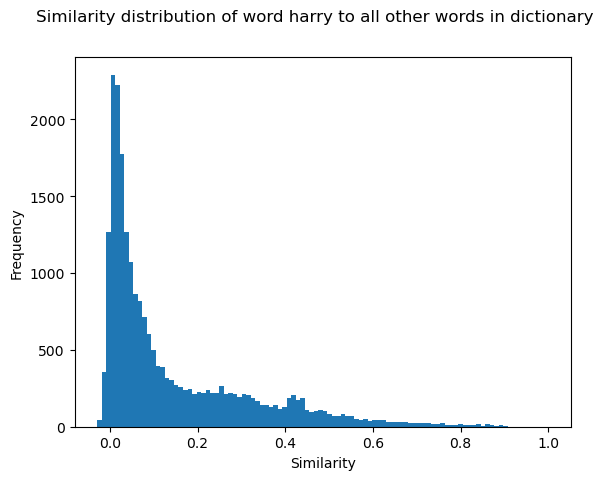

In [22]:
fig, ax = plt.subplots()
fig.suptitle(f"Similarity distribution of word {target_word} to all other words in dictionary")
ax.hist(similarities.cpu().numpy(), bins=100)
ax.set_xlabel("Similarity")
ax.set_ylabel("Frequency")